In [12]:
pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas_datareader as pdr

In [14]:
key="6198db3f4cbf60cd8a964dbd7b9f14e0ceb86146"

In [15]:
df=pdr.get_data_tiingo('AAPL', api_key=key)

C:\Users\anand\AppData\Roaming\Python\Python39\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [16]:
df.to_csv('AAPL.csv')

In [17]:
import pandas as pd

In [18]:
df=pd.read_csv('AAPL.csv')

In [19]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-01-30 00:00:00+00:00,166.97,167.37,164.70,165.53,45137026,39.640986,39.735952,39.102057,39.299110,180548104,0.0,1.0
1,AAPL,2018-01-31 00:00:00+00:00,167.43,168.44,166.50,166.87,30984099,39.750196,39.989984,39.529402,39.617245,123936396,0.0,1.0
2,AAPL,2018-02-01 00:00:00+00:00,167.78,168.62,166.76,167.17,38099665,39.833291,40.032719,39.591129,39.688469,152398660,0.0,1.0
3,AAPL,2018-02-02 00:00:00+00:00,160.50,166.80,160.10,166.00,85436075,38.104919,39.600626,38.009953,39.410695,341744300,0.0,1.0
4,AAPL,2018-02-05 00:00:00+00:00,156.49,163.88,156.00,159.10,66090446,37.152889,38.907377,37.036556,37.772539,264361784,0.0,1.0


In [20]:
df1=df.reset_index()['close']

In [21]:
df1.shape

(1258,)

In [22]:
df1

0       166.97
1       167.43
2       167.78
3       160.50
4       156.49
         ...  
1253    141.11
1254    142.53
1255    141.86
1256    143.96
1257    145.93
Name: close, Length: 1258, dtype: float64

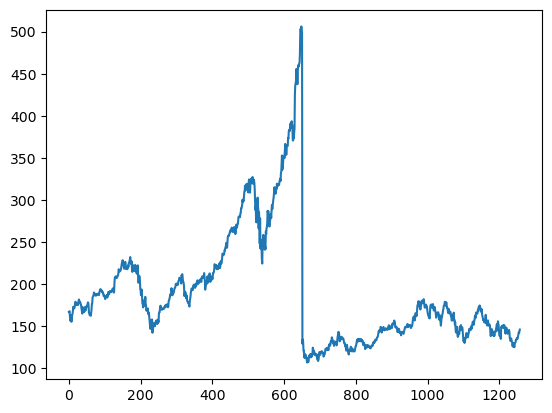

In [23]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [24]:
### LSTM are very sensitive to the scale of data. So we apply MinMax scaler

In [25]:
import numpy as np

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [27]:
df1

array([[0.15060739],
       [0.15175955],
       [0.15263619],
       ...,
       [0.08771446],
       [0.09297433],
       [0.09790858]])

In [28]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1):1]

In [29]:
print(train_data.shape),print(test_data.shape)

(817, 1)
(441, 1)


(None, None)

In [30]:
import numpy
#convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY=[], []
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX), numpy.array(dataY)

In [31]:
#reshape into X=t,t+1,t+2,t+3,t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test, y_test=create_dataset(test_data, time_step)

In [32]:
print(X_train.shape),print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [33]:
print(X_test.shape),print(y_test.shape)

(340, 100)
(340,)


(None, None)

In [34]:
#reshape input to be [samples,time_steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [35]:
###Create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [36]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 16s 334ms/step - loss: 0.0385 - val_loss: 6.4523e-04
Epoch 2/100
12/12 [==============================] - 2s 172ms/step - loss: 0.0151 - val_loss: 0.0056
Epoch 3/100
12/12 [==============================] - 2s 173ms/step - loss: 0.0104 - val_loss: 7.2714e-04
Epoch 4/100
12/12 [==============================] - 2s 168ms/step - loss: 0.0104 - val_loss: 0.0035
Epoch 5/100
12/12 [==============================] - 2s 171ms/step - loss: 0.0099 - val_loss: 8.8421e-04
Epoch 6/100
12/12 [==============================] - 2s 166ms/step - loss: 0.0075 - val_loss: 3.4809e-04
Epoch 7/100
12/12 [==============================] - 2s 152ms/step - loss: 0.0071 - val_loss: 6.9222e-04
Epoch 8/100
12/12 [==============================] - 2s 164ms/step - loss: 0.0074 - val_loss: 3.2195e-04
Epoch 9/100
12/12 [==============================] - 2s 162ms/step - loss: 0.0060 - val_loss: 3.1537e-04
Epoch 10/100
12/12 [==============================] - 2s 162ms

12/12 [==============================] - 2s 169ms/step - loss: 0.0016 - val_loss: 2.6157e-04
Epoch 79/100
12/12 [==============================] - 2s 172ms/step - loss: 0.0019 - val_loss: 7.0682e-04
Epoch 80/100
12/12 [==============================] - 2s 169ms/step - loss: 0.0041 - val_loss: 4.3112e-04
Epoch 81/100
12/12 [==============================] - 2s 167ms/step - loss: 0.0019 - val_loss: 2.6910e-04
Epoch 82/100
12/12 [==============================] - 2s 173ms/step - loss: 0.0023 - val_loss: 6.3733e-04
Epoch 83/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0019 - val_loss: 3.8508e-04
Epoch 84/100
12/12 [==============================] - 2s 173ms/step - loss: 0.0018 - val_loss: 2.7453e-04
Epoch 85/100
12/12 [==============================] - 2s 174ms/step - loss: 0.0016 - val_loss: 2.4208e-04
Epoch 86/100
12/12 [==============================] - 2s 167ms/step - loss: 0.0015 - val_loss: 2.8476e-04
Epoch 87/100
12/12 [==============================] - 2s 16

In [39]:
import tensorflow as tf

In [40]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 32ms/step


In [41]:
#transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [42]:
#Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

232.38949941426736

In [43]:
###Test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

157.72305023713452

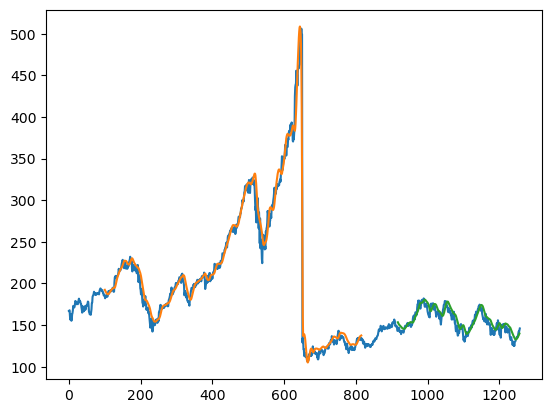

In [44]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [45]:
len(test_data)

441

In [46]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [47]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [48]:
temp_input

[0.1194489668127739,
 0.12303068252974325,
 0.1192736380713838,
 0.12656230432060112,
 0.14174076393237317,
 0.1177207263619286,
 0.12140262993112083,
 0.11403882279273636,
 0.10985597996242946,
 0.11932373199749524,
 0.1253850970569818,
 0.1174201628052598,
 0.11496556042579836,
 0.10917971195992482,
 0.11003130870381966,
 0.11251095804633682,
 0.10770194113963677,
 0.08926737633061982,
 0.07854727614276763,
 0.08919223544145266,
 0.09833437695679392,
 0.09908578584846583,
 0.09665623043206006,
 0.08328115216030052,
 0.08410770194113959,
 0.08050093926111451,
 0.07889793362554787,
 0.09054477144646211,
 0.07899812147777074,
 0.08909204758922978,
 0.0924483406386975,
 0.09272385723231058,
 0.09154664996869122,
 0.1012648716343143,
 0.10672510958046327,
 0.11396368190356915,
 0.10647463994990602,
 0.09507827175954914,
 0.1224796493425172,
 0.11646837820914213,
 0.10973074514715087,
 0.0956543519098309,
 0.08025046963055726,
 0.07899812147777074,
 0.08035065748278014,
 0.0818033813400124

In [49]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.0885801]
101
1 day input [0.12303068 0.11927364 0.1265623  0.14174076 0.11772073 0.12140263
 0.11403882 0.10985598 0.11932373 0.1253851  0.11742016 0.11496556
 0.10917971 0.11003131 0.11251096 0.10770194 0.08926738 0.07854728
 0.08919224 0.09833438 0.09908579 0.09665623 0.08328115 0.0841077
 0.08050094 0.07889793 0.09054477 0.07899812 0.08909205 0.09244834
 0.09272386 0.09154665 0.10126487 0.10672511 0.11396368 0.10647464
 0.09507827 0.12247965 0.11646838 0.10973075 0.09565435 0.08025047
 0.07899812 0.08035066 0.08180338 0.07020664 0.10026299 0.10735128
 0.10379461 0.10820288 0.10507201 0.10990607 0.11133375 0.10311835
 0.10855354 0.11078272 0.10336882 0.09362555 0.08598622 0.10316844
 0.10386976 0.10261741 0.09966187 0.0903444  0.08541014 0.08969317
 0.08846587 0.09430182 0.09675642 0.0910958  0.07428929 0.06930495
 0.0639449  0.06376957 0.07165936 0.06359424 0.0626675  0.05808391
 0.04809017 0.05703193 0.05783344 0.04566061 0.04889167 0.04553538
 0.05705698 0.05838447 0.05983719 0

8 day output [[0.10298071]]
9 day input [0.11932373 0.1253851  0.11742016 0.11496556 0.10917971 0.11003131
 0.11251096 0.10770194 0.08926738 0.07854728 0.08919224 0.09833438
 0.09908579 0.09665623 0.08328115 0.0841077  0.08050094 0.07889793
 0.09054477 0.07899812 0.08909205 0.09244834 0.09272386 0.09154665
 0.10126487 0.10672511 0.11396368 0.10647464 0.09507827 0.12247965
 0.11646838 0.10973075 0.09565435 0.08025047 0.07899812 0.08035066
 0.08180338 0.07020664 0.10026299 0.10735128 0.10379461 0.10820288
 0.10507201 0.10990607 0.11133375 0.10311835 0.10855354 0.11078272
 0.10336882 0.09362555 0.08598622 0.10316844 0.10386976 0.10261741
 0.09966187 0.0903444  0.08541014 0.08969317 0.08846587 0.09430182
 0.09675642 0.0910958  0.07428929 0.06930495 0.0639449  0.06376957
 0.07165936 0.06359424 0.0626675  0.05808391 0.04809017 0.05703193
 0.05783344 0.04566061 0.04889167 0.04553538 0.05705698 0.05838447
 0.05983719 0.06675016 0.06654978 0.06993112 0.07288666 0.07105823
 0.07120852 0.07772073

18 day output [[0.11597045]]
19 day input [0.08919224 0.09833438 0.09908579 0.09665623 0.08328115 0.0841077
 0.08050094 0.07889793 0.09054477 0.07899812 0.08909205 0.09244834
 0.09272386 0.09154665 0.10126487 0.10672511 0.11396368 0.10647464
 0.09507827 0.12247965 0.11646838 0.10973075 0.09565435 0.08025047
 0.07899812 0.08035066 0.08180338 0.07020664 0.10026299 0.10735128
 0.10379461 0.10820288 0.10507201 0.10990607 0.11133375 0.10311835
 0.10855354 0.11078272 0.10336882 0.09362555 0.08598622 0.10316844
 0.10386976 0.10261741 0.09966187 0.0903444  0.08541014 0.08969317
 0.08846587 0.09430182 0.09675642 0.0910958  0.07428929 0.06930495
 0.0639449  0.06376957 0.07165936 0.06359424 0.0626675  0.05808391
 0.04809017 0.05703193 0.05783344 0.04566061 0.04889167 0.04553538
 0.05705698 0.05838447 0.05983719 0.06675016 0.06654978 0.06993112
 0.07288666 0.07105823 0.07120852 0.07772073 0.08583594 0.08939261
 0.08771446 0.09297433 0.09790858 0.0885801  0.09127429 0.09356444
 0.09552057 0.0972381

28 day output [[0.1290626]]
29 day input [0.08909205 0.09244834 0.09272386 0.09154665 0.10126487 0.10672511
 0.11396368 0.10647464 0.09507827 0.12247965 0.11646838 0.10973075
 0.09565435 0.08025047 0.07899812 0.08035066 0.08180338 0.07020664
 0.10026299 0.10735128 0.10379461 0.10820288 0.10507201 0.10990607
 0.11133375 0.10311835 0.10855354 0.11078272 0.10336882 0.09362555
 0.08598622 0.10316844 0.10386976 0.10261741 0.09966187 0.0903444
 0.08541014 0.08969317 0.08846587 0.09430182 0.09675642 0.0910958
 0.07428929 0.06930495 0.0639449  0.06376957 0.07165936 0.06359424
 0.0626675  0.05808391 0.04809017 0.05703193 0.05783344 0.04566061
 0.04889167 0.04553538 0.05705698 0.05838447 0.05983719 0.06675016
 0.06654978 0.06993112 0.07288666 0.07105823 0.07120852 0.07772073
 0.08583594 0.08939261 0.08771446 0.09297433 0.09790858 0.0885801
 0.09127429 0.09356444 0.09552057 0.09723818 0.09879645 0.10025097
 0.10163793 0.10298071 0.10429487 0.10559127 0.10687823 0.10816196
 0.1094472  0.1107373  0

In [50]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


In [51]:
import matplotlib.pyplot as plt

In [52]:
len(df1)

1258

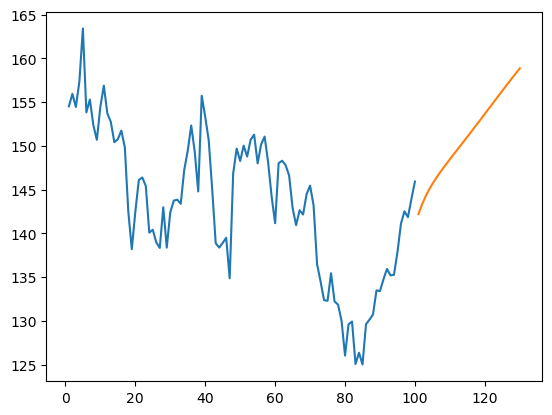

In [53]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

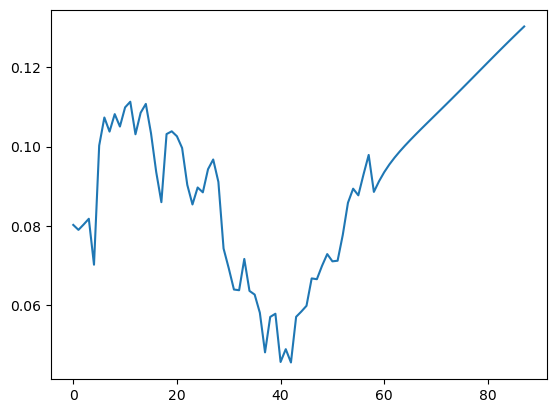

In [54]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [55]:
df3=scaler.inverse_transform(df3).tolist()

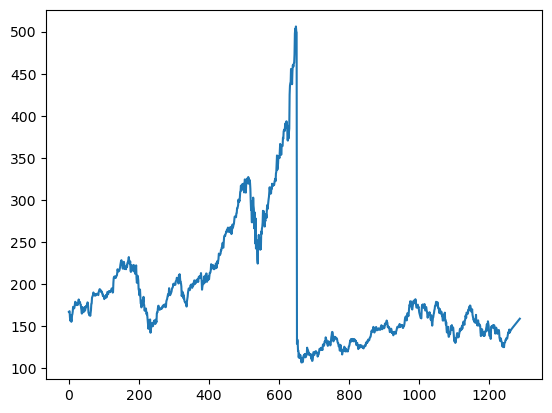

In [56]:
plt.plot(df3)